<img src="siamese_network.png" style="width:450px;height:300px;float:middle">
以上為siamese network的計算流程

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data # Import MNIST data
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets('MNIST_data' , one_hot = False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
aug = ImageDataGenerator(rotation_range = 25,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1 ,
                         shear_range = 0.2 ,
                         zoom_range = 0.2,
                         fill_mode = 'nearest')

def get_train_batch(base_num = 2000 , batch_size = 500 , class_num = 10):
    # 收集500組image，每一組會有2張image
    # 其中250組為similar_image_set，每一組image中包含2張相同class的image
    # 另外250組image為dissimilar_image_set，每一組image中包含2張不同class的image
    image_set , label_set = mnist.train.next_batch(base_num)
    image_set = np.reshape(image_set , [-1 , 28 , 28 , 1])
    
#     # 可以減少overfitting的情況
#     augmentation_data = aug.flow(np.reshape(image_set , [-1 , 28 , 28 , 1]) ,
#                                  label_set ,
#                                  shuffle = True ,
#                                  batch_size = base_num)
#     image_set , label_set = augmentation_data[0][0] , augmentation_data[0][1]

    similar_image_set = None
    similar_label_set = None
    for i in range(0 , class_num):
        # 從第i個class中的image中挑出50張image成為image_set[index]
        # image_set[index] → [50 , 28 , 28 , 1]
        index = np.random.choice(np.where(label_set == i)[0] ,
                                 size = int(batch_size / class_num) ,
                                 replace = False)

        # 將image_set[index]中的image分為25組image，成為similar_image_pair
        # 每一組image中包含2張相同class的image
        # similar_image_pair → [25 , 2 , 28 , 28 , 1]
        similar_image_pair = np.reshape(image_set[index] , [int(batch_size / 2 / class_num) , 2 , 28 , 28 , 1])
        if similar_image_set is None:
            similar_image_set = similar_image_pair
        else:
            # similar_image_set → [250 , 2 , 28 , 28 , 1] (執行迴圈10次，沿著axis 0，將similar_image_pair堆疊10次)
            similar_image_set = np.concatenate([similar_image_set , similar_image_pair] , axis = 0)

        # 決定每一組image所對應的label
        # similar_label_pair → [25 , 2 , 10]
        # 手寫數字為0的similar_label_pair[: , : , 0] = 1
        # 手寫數字為1的similar_label_pair[: , : , 1] = 1
        # 手寫數字為2的similar_label_pair[: , : , 2] = 1
        #                   ...
        # 手寫數字為9的similar_label_pair[: , : , 9] = 1
        similar_label_pair = np.zeros([int(batch_size / 2 / class_num) , 2 , class_num])
        similar_label_pair[: , : , i] = 1
        if similar_label_set is None:
            similar_label_set = similar_label_pair
        else:
            # similar_label_set → [250 , 2 , 10] (執行迴圈10次，沿著axis 0，將similar_label_pair堆疊10次)
            similar_label_set = np.concatenate([similar_label_set , similar_label_pair] , axis = 0)


    dissimilar_image_set = None
    dissimilar_label_set = None
    # 從0~base_num中隨機挑出250個不重複的數字成為index_a_set
    # index_a_set為dissimilar_image_set中每組image中第1張image的index
    index_a_set = np.random.choice(range(0 , base_num) ,
                                   size = int(batch_size / 2) ,
                                   replace = False)
    for i in range(0 , int(batch_size / 2)):
        # label_a為dissimilar_image_set中每組image中第1張image的label
        index_a = index_a_set[i]
        label_a = label_set[index_a]
        # label_b為dissimilar_image_set中每組image中第2張image的label
        # 執行迴圈直到label_a不等於label_b為止
        while True:
            index_b = np.random.randint(0 , base_num)
            label_b = label_set[index_b]
            if label_b != label_a:
                break

        # image_set[index_a] → [28 , 28 , 1] ⟹ image_a → [1 , 28 , 28 , 1]
        # image_set[index_b] → [28 , 28 , 1] ⟹ image_b → [1 , 28 , 28 , 1]
        image_a = np.reshape(image_set[index_a] , [1 , 28 , 28 , 1])
        image_b = np.reshape(image_set[index_b] , [1 , 28 , 28 , 1])
        # dissimilar_image_pair → [2 , 28 , 28 , 1]
        dissimilar_image_pair = np.concatenate([image_a , image_b] , axis = 0)
        # dissimilar_image_pair → [1 , 2 , 28 , 28 , 1]
        dissimilar_image_pair = np.expand_dims(dissimilar_image_pair , axis = 0)

        if dissimilar_image_set is None:
            dissimilar_image_set = dissimilar_image_pair
        else:
            # dissimilar_image_set → [250 , 2 , 28 , 28 , 1] (執行迴圈250次，沿著axis 0，將dissimilar_image_pair堆疊250次)
            dissimilar_image_set = np.concatenate([dissimilar_image_set , dissimilar_image_pair] , axis = 0)

        # class_label_a → [1 , 10]
        # class_label_b → [1 , 10]
        class_label_a = np.zeros([1 , class_num])
        class_label_a[0 , label_a] = 1
        class_label_b = np.zeros([1 , class_num])
        class_label_b[0 , label_b] = 1
        # dissimilar_label_pair → [2 , 10]
        dissimilar_label_pair = np.concatenate([class_label_a , class_label_b] , axis = 0)
        # dissimilar_label_pair → [1 , 2 , 10]
        dissimilar_label_pair = np.expand_dims(dissimilar_label_pair , axis = 0)
        if dissimilar_label_set is None:
            dissimilar_label_set = dissimilar_label_pair
        else:
            # dissimilar_label_set → [250 , 2 , 10] (執行迴圈250次，沿著axis 0，將dissimilar_label_pair堆疊250次)
            dissimilar_label_set = np.concatenate([dissimilar_label_set , dissimilar_label_pair] , axis = 0)

    # image_set → [500 , 2 , 28 , 28 , 1]
    image_set = np.concatenate([similar_image_set , dissimilar_image_set] , axis = 0)
    # label_set → [500 , 2 , 10]
    label_set = np.concatenate([similar_label_set , dissimilar_label_set] , axis = 0)

    arr = np.arange(0 , batch_size)
    np.random.shuffle(arr)

    image_set = image_set[arr]
    label_set  = label_set[arr]

    return image_set , label_set

In [4]:
def get_test_batch(data_num = 8000 , class_num = 10):
    image_set , label_set = mnist.train.next_batch(data_num)
    image_set_test = np.reshape(image_set , [-1 , 28 , 28 , 1])
    label_set_test = label_set
    return image_set_test , label_set_test

In [5]:
def feature_extractor(input_ , reuse = False):
    if reuse : tf.get_variable_scope().reuse_variables()
    with tf.variable_scope('conv1'):
        conv_output_1 = tf.contrib.layers.conv2d(input_ , 32 , [7 , 7] ,
                                                 activation_fn = tf.nn.relu , padding='SAME' ,
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_1 = tf.contrib.layers.max_pool2d(conv_output_1 , [2, 2] , padding = 'SAME')

    with tf.variable_scope('conv2'):
        conv_output_2 = tf.contrib.layers.conv2d(conv_pooling_1  , 64 , [5 , 5] ,
                                                 activation_fn = tf.nn.relu , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_2 = tf.contrib.layers.max_pool2d(conv_output_2 , [2, 2] , padding = 'SAME')

    with tf.variable_scope('conv3'):
        conv_output_3 = tf.contrib.layers.conv2d(conv_pooling_2 , 128 , [3 , 3] ,
                                                 activation_fn = tf.nn.relu, padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_3 = tf.contrib.layers.max_pool2d(conv_output_3 , [2 , 2], padding = 'SAME')

    with tf.variable_scope('conv4'):
        conv_output_4 = tf.contrib.layers.conv2d(conv_pooling_3 , 256, [1 , 1],
                                                 activation_fn = tf.nn.relu , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_4 = tf.contrib.layers.max_pool2d(conv_output_4 , [2 , 2] , padding = 'SAME')

    with tf.variable_scope('conv5') :
        conv_output_5 = tf.contrib.layers.conv2d(conv_pooling_4 , 2, [1 , 1],
                                                 activation_fn = None , padding = 'SAME',
                                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        conv_pooling_5 = tf.contrib.layers.max_pool2d(conv_output_5 , [2 , 2] , padding = 'SAME')

    with tf.variable_scope('flatten'):
        output_flatten = tf.contrib.layers.flatten(conv_pooling_5)

    return output_flatten

In [6]:
class_num = 10

input_image = tf.placeholder(tf.float32 , [None , 2 , 28 , 28 , 1])
x_a = input_image[: , 0 , : , : , :]
x_b = input_image[: , 1 , : , : , :]
y_true = tf.placeholder(tf.float32 , [None , 2 , class_num])
y_true_a = y_true[: , 0 , :]
y_true_b = y_true[: , 1 , :]
keep_prob = tf.placeholder(tf.float32)

In [7]:
with tf.variable_scope('feature_extractor'):
    embedding_a = feature_extractor(x_a , reuse = False)
    embedding_b = feature_extractor(x_b , reuse = True)

with tf.variable_scope('euclidean_distance'):
    distance = tf.reduce_sum(tf.pow(embedding_a - embedding_b , 2) , axis = 1)
    distance = tf.sqrt(tf.maximum(distance , 1e-9))

# 仿造一般multi-classification中cross entropy的寫法
with tf.variable_scope('contrastive_loss'):
    margin = 1
    # decision_similarity其實就是y_true_a與y_true_b做內積的結果
    # 只要y_true_a的1與y_true_b的1出現在同一個位置，也就是x_a與x_b屬於同一個class，decision_similarity就是1
    # 只要y_true_a的1與y_true_b的1出現在不同的位置，也就是x_a與x_b屬於不同的class，decision_similarity就是0
    # 讓decision_similarity等於1或等於0的情況有非常多種，這裡針對1筆data，並以兩種情況舉例:
    # ❶ y_true_a → [0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0]  &  y_true_b → [0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0] ⟹ decision_similarity = 1  ,  1 - decision_similarity = 0
    # ❶ contrastive_loss = similarity = tf.square(distance)
    # ❷ y_true_a → [0 , 1 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0]  &  y_true_b → [1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0] ⟹ decision_similarity = 0  ,  1 - decision_similarity = 1
    # ❷ contrastive_loss = dissimilarity = tf.square(tf.maximum(margin - distance , 0))
    decision_similarity = tf.reduce_sum(tf.multiply(y_true_a , y_true_b) , axis = 1)
    similarity = tf.multiply(decision_similarity , tf.square(distance))
    dissimilarity = tf.multiply(1 - decision_similarity , tf.square(tf.maximum(margin - distance , 0)))
    contrastive_loss = tf.reduce_mean(similarity + dissimilarity)
    
with tf.variable_scope('optimizer'):    
    train_op = tf.train.AdamOptimizer(1e-3).minimize(contrastive_loss)    

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

test_image , test_label = get_test_batch()
embedding_vector_list = []
for batch_i in range(0 , 3200):
    train_image_batch , train_label_batch = get_train_batch()

    _ , train_loss = sess.run([train_op , contrastive_loss] , 
                              feed_dict = {input_image : train_image_batch , y_true : train_label_batch})
    
    if batch_i % 160 == 0:
        print('=' * 30)
        print('batch_i : {}'.format(batch_i))
        print('training_loss : {:.4f}'.format(train_loss))
    
    if batch_i % 200 == 0:
        embedding_vector = sess.run(embedding_a , feed_dict = {x_a : test_image})
        embedding_vector_list.append(embedding_vector) 

batch_i : 0
training_loss : 0.4804
batch_i : 160
training_loss : 0.0764
batch_i : 320
training_loss : 0.0533
batch_i : 480
training_loss : 0.0402
batch_i : 640
training_loss : 0.0422
batch_i : 800
training_loss : 0.0284
batch_i : 960
training_loss : 0.0207
batch_i : 1120
training_loss : 0.0163
batch_i : 1280
training_loss : 0.0135
batch_i : 1440
training_loss : 0.0122
batch_i : 1600
training_loss : 0.0124
batch_i : 1760
training_loss : 0.0105
batch_i : 1920
training_loss : 0.0076
batch_i : 2080
training_loss : 0.0056
batch_i : 2240
training_loss : 0.0036
batch_i : 2400
training_loss : 0.0050
batch_i : 2560
training_loss : 0.0030
batch_i : 2720
training_loss : 0.0026
batch_i : 2880
training_loss : 0.0019
batch_i : 3040
training_loss : 0.0033


可以發現隨著訓練的演進，每個手寫數字所屬的cluster會分得越來越遠

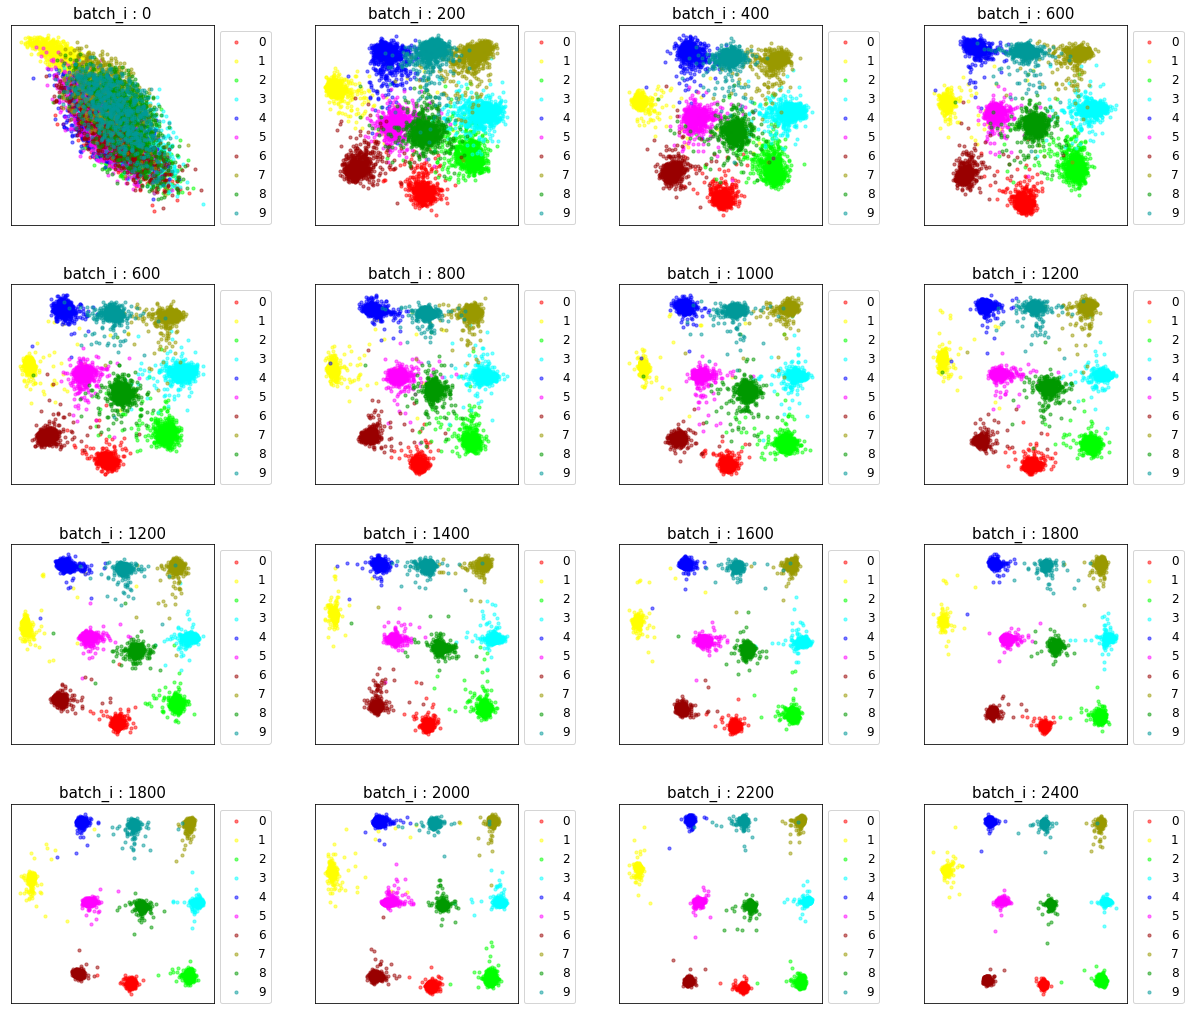

In [9]:
fig , ax = plt.subplots(4 , 4 , figsize = (20 , 18))
plt.subplots_adjust(wspace = 0.5 , hspace = 0.3)

colors_set = ['#ff0000' , '#ffff00' , '#00ff00' , '#00ffff' ,  '#0000ff' , 
              '#ff00ff' , '#990000' , '#999900' , '#009900' , '#009999']

for i in range(0 , 4):
    for j in range(0 , 4):
        embedding_vector = embedding_vector_list[4 * i + j]
        for class_ in range(0 , class_num):
            index = (test_label == class_)
            ax[i , j].scatter(embedding_vector[index , 0] , embedding_vector[index , 1] , 
                              alpha = 0.5 , s = 10 , c = colors_set[class_] , label = str(class_))
            ax[i , j].set_title('batch_i : {:1d}'.format((3 * i + j) * 200) , fontsize = 15) 
            ax[i , j].set_xticks([])
            ax[i , j].set_yticks([])
            box = ax[i , j].get_position()
            ax[i , j].set_position([box.x0 , box.y0 , box.width , box.height])
            ax[i , j].legend(loc='upper left' , bbox_to_anchor = (1 , 1) , ncol = 1 , fontsize = 12)

image檢索 → 要從search_image中找出與retrieval_image最相近的50張image

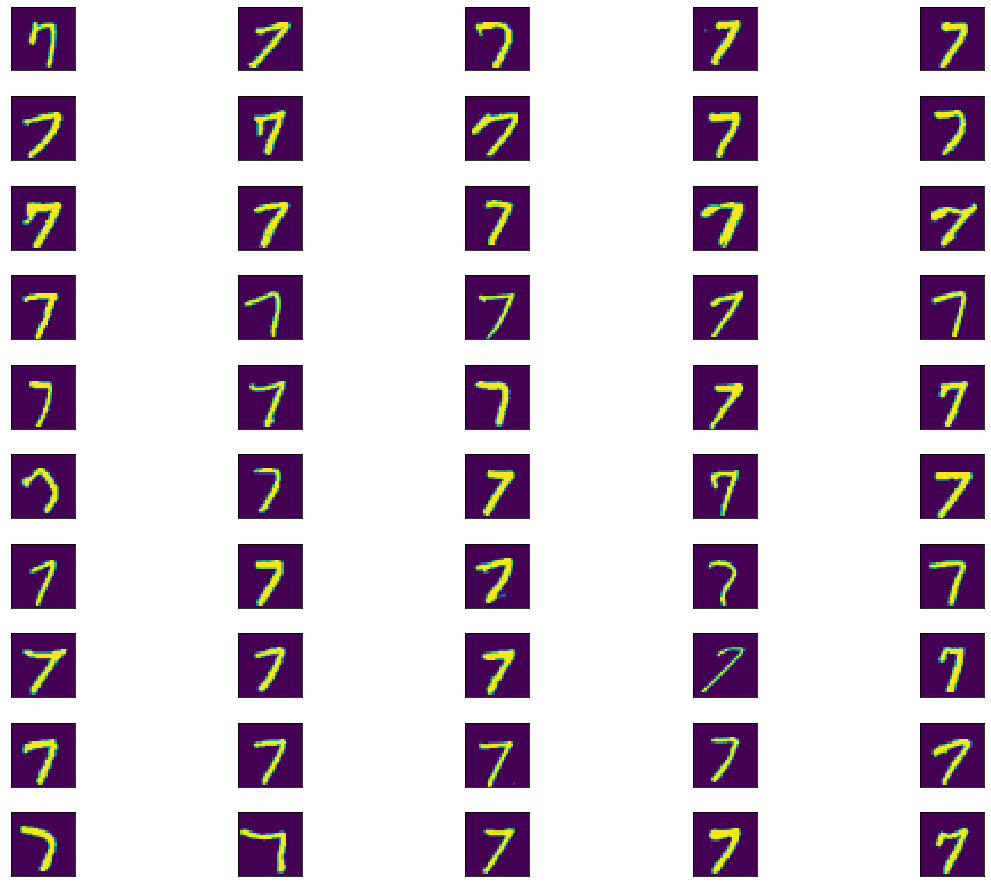

In [10]:
search_image , search_label = get_test_batch()

# 讀取已經存好的手寫數字辨識圖片
retrieval_image = np.load('retrieval_image.npy')

# retrieval_image複製的8000次
retrieval_image = [retrieval_image for _ in range(0 , 8000)]
retrieval_image = np.array(retrieval_image)

# 先計算retrieval_image與search_image分別轉換成的embedding vector
# 再計算兩者所轉換的embedding vector的距離，即為search_distance
# 並取出距離最短的前50名的index，即為top_50
search_distance = sess.run(distance , feed_dict = {x_a : retrieval_image , x_b : search_image})
top_50 = search_distance.argsort()[:50]

fig, ax = plt.subplots(10 , 5 , figsize = (20 , 16))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
for i in range(0 , 10):
    for j in range(0 , 5):
        index = top_50[5 * i + j]
        ax[i , j].imshow(search_image[index , : , : , 0])
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])

outlier檢測 → 從retrieval_image中找出寫得最潦草的

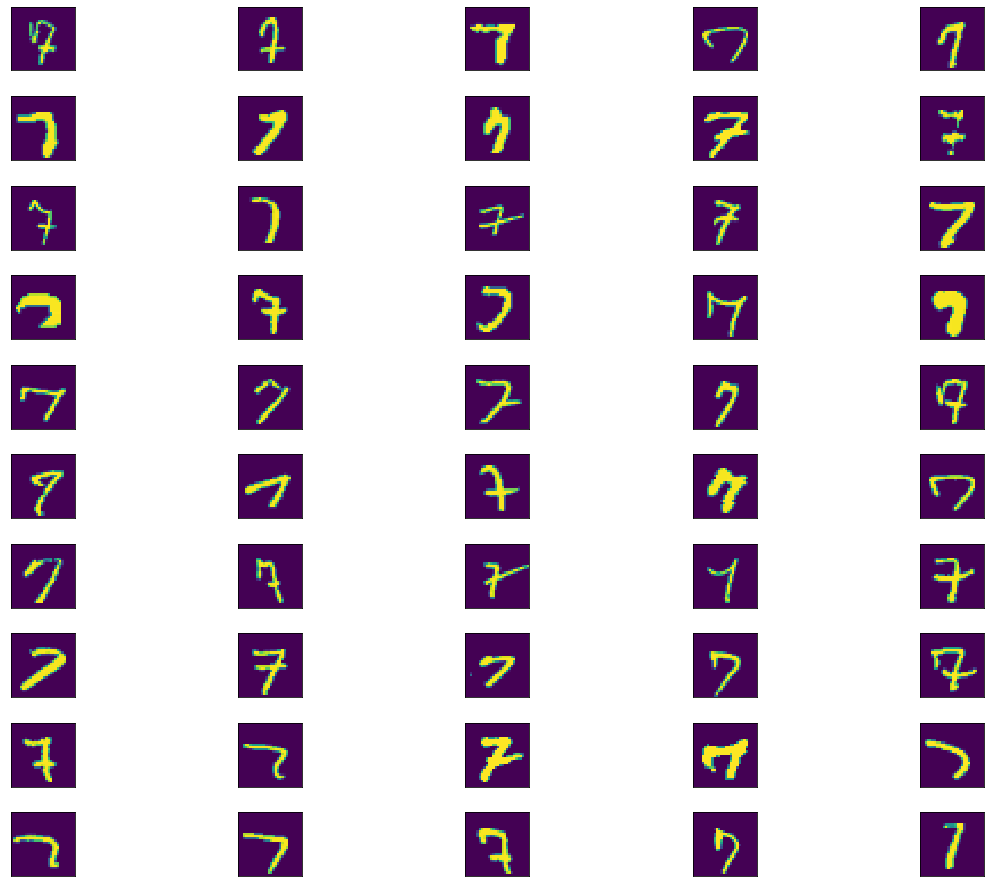

In [11]:
search_image , search_label = get_test_batch()

query_number = 7
index = (search_label == query_number)
retrieval_image = search_image[index]

# 計算retrieval_image所轉換的embedding vector，接著再計算這些embedding vector的平均，即為retrieval_vector_mean
# 接著再將retrieval_vector_mean複製len(retrieval_vector)次
retrieval_vector = sess.run(embedding_a , feed_dict = {x_a : retrieval_image})
retrieval_vector_mean = retrieval_vector.mean(axis = 0)
retrieval_vector_mean = [retrieval_vector_mean for _ in range(0 , len(retrieval_vector))]
retrieval_vector_mean = np.array(retrieval_vector_mean)

# 計算retrieval_vector_mean與retrieval_vector的距離
# 並取出距離最長的前50名的index，即為bottom_50
search_distance = sess.run(distance , feed_dict = {embedding_a : retrieval_vector_mean , embedding_b : retrieval_vector})
bottom_50 = search_distance.argsort()[-50:]

fig, ax = plt.subplots(10 , 5 , figsize = (20 , 16))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.4)
for i in range(0 , 10):
    for j in range(0 , 5):
        index = bottom_50[5 * i + j]
        ax[i , j].imshow(retrieval_image[index , : , : , 0])
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])